<a href="https://colab.research.google.com/github/slala2121/Triplet-net-keras/blob/COS597D/Triplet_NN_Test_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [0]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras import backend as K
print("GPU USAGE: ", K.tensorflow_backend._get_available_gpus())
import os
import pickle
import matplotlib.pyplot as plt

GPU USAGE:  ['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
from itertools import permutations

In [0]:
import seaborn as sns

In [0]:
from keras.datasets import mnist
from sklearn.manifold import TSNE

In [0]:
from sklearn.svm import SVC

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

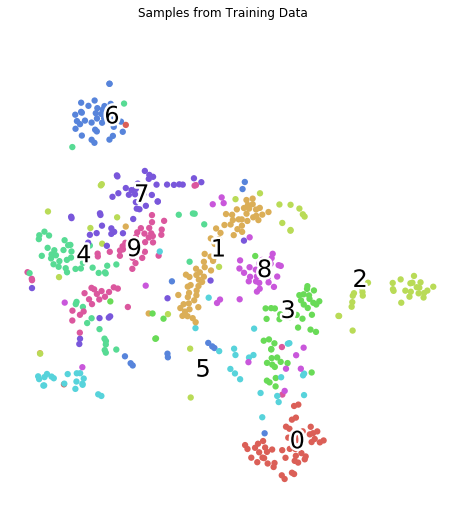

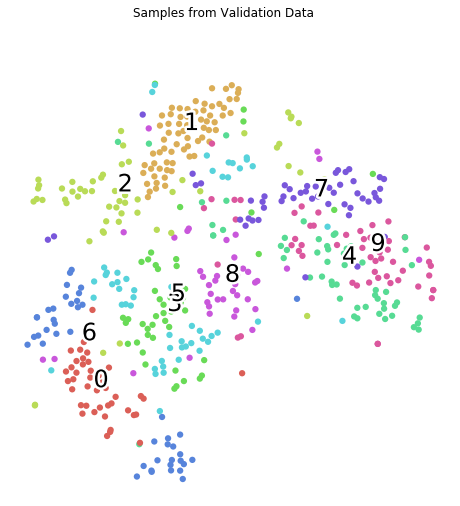

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

In [0]:
Classifier_input = Input((784,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

In [0]:
from sklearn.preprocessing import LabelBinarizer

In [0]:
le = LabelBinarizer()

In [0]:
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

In [0]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/10


60000/60000 [==============================] - 13s 217us/step - loss: 6.0952 - acc: 0.6155 - val_loss: 4.5672 - val_acc: 0.7136
Epoch 2/10
60000/60000 [==============================] - 5s 88us/step - loss: 4.3974 - acc: 0.7239 - val_loss: 4.2874 - val_acc: 0.7314
Epoch 3/10
60000/60000 [==============================] - 5s 88us/step - loss: 4.3514 - acc: 0.7273 - val_loss: 4.3027 - val_acc: 0.7305
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 4.2320 - acc: 0.7351 - val_loss: 4.2865 - val_acc: 0.7320
Epoch 5/10
60000/60000 [==============================] - 5s 91us/step - loss: 4.2727 - acc: 0.7329 - val_loss: 4.3418 - val_acc: 0.7284
Epoch 6/10
60000/60000 [==============================] - 6s 96us/step - loss: 4.2065 - acc: 0.7376 - val_loss: 4.1700 - val_acc: 0.7398
Epoch 7/10
60000/60000 [====

In [0]:
"""
Dimensions:
# samples, triplet, image size

each triplet is ordered: anchor, pos, neg
"""

def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [0]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

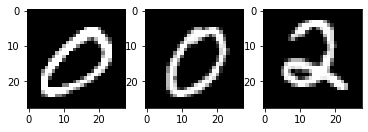

In [0]:
sample=X_train[0]

fig,ax=plt.subplots(nrows=1,ncols=3)
ax=ax.ravel()
ax[0].imshow(np.reshape(sample[0],(28,28)),cmap='gray')
ax[1].imshow(np.reshape(sample[1],(28,28)),cmap='gray')
ax[2].imshow(np.reshape(sample[2],(28,28)),cmap='gray')

## Triplet NN

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [0]:
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)


y_pred.shape =  Tensor("merged_layer/concat:0", shape=(?, 12), dtype=float32)


In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            876036      anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [0]:
num_train_samples= 100 # X_train.shape[0]
num_test_samples= 10 # X_test.shape[0]
batch_size = 2 # 512 
num_epochs=5

Anchor = X_train[:num_train_samples,0,:].reshape(-1,28,28,1)
Positive = X_train[:num_train_samples,1,:].reshape(-1,28,28,1)
Negative = X_train[:num_train_samples,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:num_test_samples,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:num_test_samples,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:num_test_samples,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), 
          batch_size=batch_size, epochs=num_epochs)

Train on 100 samples, validate on 10 samples
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [0]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [0]:
model_path=os.path.join('drive','My Drive','Colab Notebooks',
                        'Triplet-net-keras-master',
                        'triplet_model_MNIST.hdf5')
trained_model.load_weights(model_path)

In [0]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))

train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

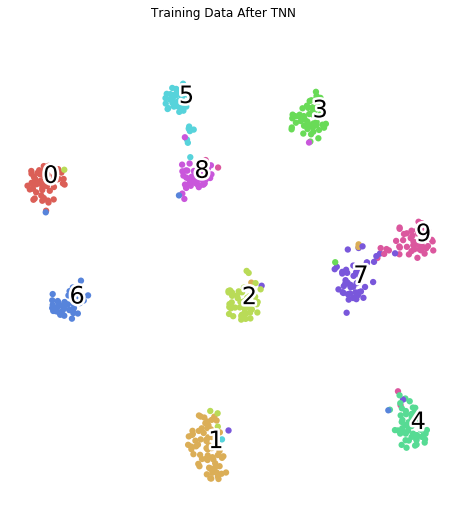

In [0]:
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")

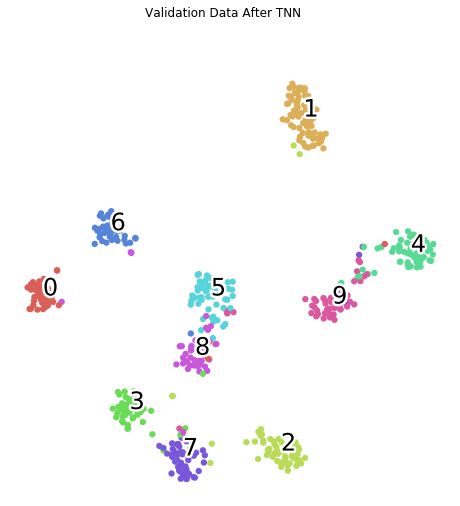

In [0]:
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")

In [0]:
# extract features and train a classifier using the learned features

X_train_trm = trained_model.predict(x_train.reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test.reshape(-1,28,28,1))

Classifier_input = Input((4,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm,y_train_onehot, validation_data=(X_test_trm,y_test_onehot),epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 4.4070 - acc: 0.6653 - val_loss: 1.9697 - val_acc: 0.8319
Epoch 2/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.5289 - acc: 0.9174 - val_loss: 0.2535 - val_acc: 0.9354
Epoch 3/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2270 - acc: 0.9371 - val_loss: 0.2048 - val_acc: 0.9404
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1977 - acc: 0.9405 - val_loss: 0.1908 - val_acc: 0.9430
Epoch 5/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1904 - acc: 0.9419 - val_loss: 0.1850 - val_acc: 0.9451
Epoch 6/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.1876 - acc: 0.9423 - val_loss: 0.1842 - val_acc: 0.9440
Epoch 7/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1863 - acc: 0.9428 - val_loss: 0.1822 - val_acc